Created by Daniel Baur on 17th November 2020

#### General
This notebook and the corresponding Python script are meant to assess the quality of our cable internet connection. The drastically decrease upload and download rates along with the constant connection losses make surfing impossible. Therefore I wrote this code to write the upload and download rates into a SQLite database so we can document the issues.

#### Workflow
The RaspberryPi is connected to the cable modem via both WiFi and ethernet. It is accessed by hooking it up to the Beamer. In the terminal one can start the data acquisition by executing the following from within the project folder (i.e. ``/home/pi/Desktop/ispeed/``):<br>
``$ python3 ispeed.py --runmode main``<br>
This will measure both the upload and downlaod speed every now and then and store the result in a sqlite database file within ``/home/pi/Desktop/ispeed/data/``.<br>
This data can be retrieved by executing the ``ispeed.ispeed_copy()`` command below. By executing ``ispeed.ispeed_update()`` one can further copy the current version of ``ispeed.py`` onto the RaspberryPi. The data is accessed as demonstrated in the cell ``Investigating Database Entries``.

#### Notes
- It was not possible (at least with reasonable effort) to remotely initiate and finish the data acqusition utilizing the ``screen`` program. This is most likely due to the fact that I obtain the data from reading in the output of ``speedtest-cli`` by retrieving it from ``std.out``. I could probably store it within a temporary file and read it in from there.
- jfk


<br>
<br>

#### Imports

In [1]:
# Python program to test internet speed 
  
import ispeed
import sqlite3
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('file://' +"/home/daniel/Desktop/arbeitsstuff/20180705__monxe/monxe_software/miscfig/danielsmplstyle.mplstyle")
import numpy as np
import datetime
import matplotlib.dates as mpldt
from matplotlib.dates import  DateFormatter





<br>
<br>

#### Updating the ispeed.py File

In [2]:
if [True,False][1]:
    ispeed.ispeed_update()


<br>
<br>

#### Retrieving the Database Files

In [3]:
if [True,False][0]:
    ispeed.ispeed_copy()

scp -r pi@192.168.0.210:/home/pi/Desktop/ispeed/data/* /home/daniel/Desktop/projects/ispeed/data/



<br>
<br>

#### Investigating Database Entries

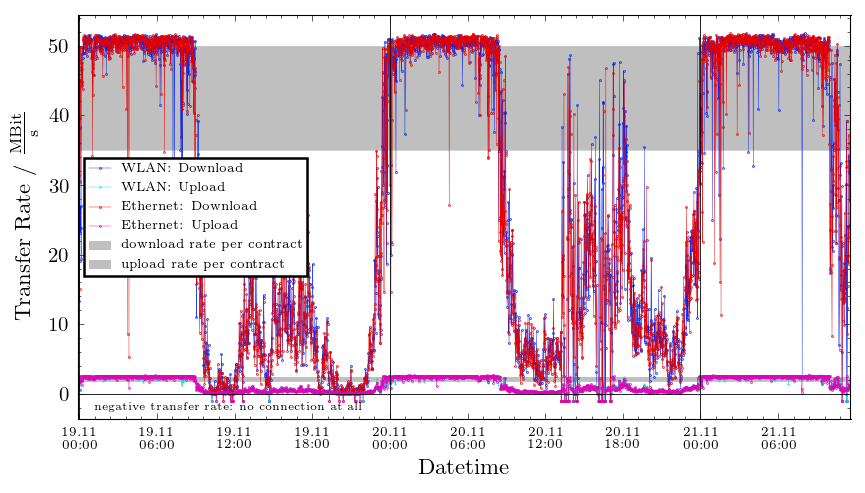

In [4]:
if [True,False][0]:

    # plot definitions
    dbname = ispeed.get_latest_filename() +"__ispeed.db"
    #dbname = "20201118_233521__ispeed.db"
    db_dtype = np.dtype([
        ("datetimestamp", np.uint64),
        ("interface", np.unicode_, 16),
        ("download_mbitps", np.float16),
        ("upload_mbitps", np.float16),
        ("ping_ms", np.float16)
    ])
    format_dtype = np.dtype([
        ("interface", np.unicode_, 16),
        ("measure", np.unicode_, 16),
        ("color", np.unicode_, 16),
        ("marker", np.unicode_, 16),
        ("legentry", np.unicode_, 32),
    ])
    format_ndarray = np.array([
        ("WLAN", "download_mbitps", "#0020f2", "o", r"WLAN: Download"),
        ("WLAN", "upload_mbitps", "#00e6da", "x", r"WLAN: Upload"),
        ("Ethernet", "download_mbitps", "#e60000", "o", r"Ethernet: Download"),
        ("Ethernet", "upload_mbitps", "#e004b8", "o", r"Ethernet: Upload"),
    ], format_dtype)

    # connecting to the database and writing the entries into a ndarray
    conn = sqlite3.connect(ispeed.data_dict["x380"]["path_data"] +dbname)
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM {} ORDER BY {} DESC".format("ispeed_data", "datetimestamp"))
    rows = cursor.fetchall()
    db_ndarray = np.array(rows, db_dtype)
    conn.close()


    # plotting data
    fig, ax1 = plt.subplots(figsize=(5.670, 3.189), dpi=150, constrained_layout=True)
    for interface in ["WLAN", "Ethernet"]:
        for measure in ["download_mbitps", "upload_mbitps"]:
            subdataset = db_ndarray[(db_ndarray["interface"]==interface)] #  & (db_ndarray["datetimestamp"]==interface)
            fd = format_ndarray[(format_ndarray["interface"]==interface) & (format_ndarray["measure"]==measure)][0]
            plt.plot_date(
                x = ispeed.plt_dates(subdataset)[0],
                y = subdataset[measure],
                xdate = True,
                ydate = False,
                color = fd["color"],
                linestyle = "-",
                linewidth = 0.2,
                marker = fd["marker"],
                markersize = 0.3,
                label = fd["legentry"]
            )

    # axes
    ax1.set_xlabel(r"Datetime")
    ax1.set_ylabel(r"Transfer Rate / $\mathrm{\frac{MBit}{s}}$")
    ax1.xaxis.set_major_formatter( DateFormatter('%d.%m\n %H:%M') )
    ax1.tick_params(axis='x', labelsize=6)
    ax1.set_xlim([min(ispeed.plt_dates(db_ndarray)[0]),max(ispeed.plt_dates(db_ndarray)[0])])

    # annotations
    ax1.axhline(y=0, color="black", linewidth=0.4)
    plt.text( # er signature
        x = 0.02,
        y = 0.03,
        transform = ax1.transAxes,
        s = r"negative transfer rate: no connection at all",
        color = "black",
        fontsize = 5,
        verticalalignment = 'center',
        horizontalalignment='left')
    plt.fill_between(ispeed.plt_dates(db_ndarray)[0], 35, 50, color='grey', alpha=0.5, edgecolor="", zorder=-1, linewidth="0.002", label=r"download rate per contract")
    plt.fill_between(ispeed.plt_dates(db_ndarray)[0], 1.8, 2.5, color='grey', alpha=0.5, edgecolor="", zorder=-1, linewidth="0.002", label=r"upload rate per contract")
    for i in range(len(ispeed.plt_dates(db_ndarray)[1])):
        ax1.axvline(x=ispeed.plt_dates(db_ndarray)[1][i], color="black", linewidth=0.4)

    # legend
    plt.legend(fontsize=6)

    # saving
    fig.savefig(ispeed.data_dict["x380"]["path_project"] +"internet_connectivity_assessment.png")
        


<br>
<br>

#### Testing Matplotlib Animations

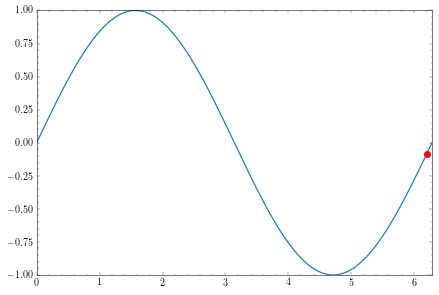

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

TWOPI = 2*np.pi

fig, ax = plt.subplots()

t = np.arange(0.0, TWOPI, 0.001)
s = np.sin(t)
l = plt.plot(t, s)

ax = plt.axis([0,TWOPI,-1,1])

redDot, = plt.plot([0], [np.sin(0)], 'ro')

def animate(i):
    redDot.set_data(i, np.sin(i))
    return redDot,

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=np.arange(0.0, TWOPI, 0.1), \
                                      interval=10, blit=True, repeat=True)

myAnimation.save('./anitests/dot_animation.mp4')
plt.show()
